In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import ttest_ind
%matplotlib inline

# Introduction
In this analysis, we look at household energy consumption, from measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). For brevity's sake, we will only be looking at a subset of this data (2007 only, 520230 records). Measurements were taken every minute (1440 each day), with the exception of missing values, which the dataset contains nearly 1.25% of the rows. Once again, for brevity's sake we will simply drop these rows.

**indexing**

The original data contains both date and time, so when reading in the data we combine these columns into one date-time column and use this as the index.

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

## Handling Missing Values
The dataset contains missing/null values in all of the columns, so let's fix that! For the sake of simplicity, we will just fill in these values with the mean of that column. We do not test if these values occur at random or not, also imputing these values using a KNN algorithm would probably be better. 

In [6]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Variables

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


  * **global_active_power:** household global minute-averaged active power (in kilowatt)
  
  * **global_reactive_power:** household global minute-averaged reactive power (in kilowatt)
  
  * **voltage:** minute-averaged voltage (in volt)
  
  * **global_intensity:** household global minute-averaged current intensity (in ampere)
  
  * **sub_metering_1:** energy sub-metering No. 1 (in watt-hour of active energy). 
    * It corresponds to the **kitchen**
     * **dishwasher**
     * **oven**
     * **microwave** (hot plates are not electric but gas powered).
     
  * **sub_metering_2:** energy sub-metering No. 2 (in watt-hour of active energy). 
    * It corresponds to the **laundry room**, 
      * **washing-machine**
      * **tumble-drier**
      * **refrigerator** 
      * **light**
      
* **sub_metering_3:** energy sub-metering No. 3 (in watt-hour of active energy). 
    * **electric water-heater**
    * **air-conditioner**

In [10]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


## Objective
For this analysis, we will assume the role of optimizing energy production from the standpoint of the energy provider/company/utility. Given only the data provided by a single household over 47 months, what predictions can we make? Specifically, can we (as the power utility) re-route power during certain times during the day (day/night), time of week (weekday/weekends) or quarterly (seasonal)?

# Data Visualization
Before we dive deeper into the data, let's take an overall look at the entire dataset.

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


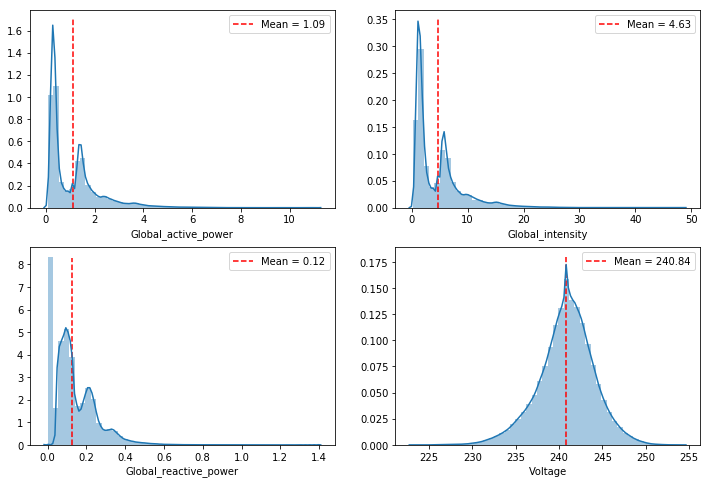

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.distplot(df.Global_active_power)
plt.vlines(df.Global_active_power.mean(), label="Mean = {}".format(round(df.Global_active_power.mean(),2)), ymin=0, ymax=1.7, linestyles="dashed", colors=["red"])
plt.legend()
plt.subplot(2,2,2)
sns.distplot(df.Global_intensity)
plt.vlines(df.Global_intensity.mean(), label="Mean = {}".format(round(df.Global_intensity.mean(),2)), ymin=0, ymax=0.35, linestyles="dashed", colors=["red"])
plt.legend()
plt.subplot(2,2,3)
sns.distplot(df.Global_reactive_power)
plt.vlines(df.Global_reactive_power.mean(), label="Mean = {}".format(round(df.Global_reactive_power.mean(),2)), ymin=0, ymax=8.3, linestyles="dashed", colors=["red"])
plt.legend()
plt.subplot(2,2,4)
sns.distplot(df.Voltage)
plt.vlines(df.Voltage.mean(), label="Mean = {}".format(round(df.Voltage.mean(),2)), ymin=0, ymax=0.18, linestyles="dashed", colors=["red"])
plt.legend()
plt.show()

**Interpretation**
Here we plot the histogram of each of the first 4 variables, and overlay a KDE curve onto it which leads me to suspect a bi-modal distribution here, possibly one during peak hours and the other for off-peak hours. This "peak" time period may not be contiguous; peak times may be morning and evening and/or weekday/weekends corresponding to a typical work schedule.

We expect the voltage readings to behave like this: 240V is a common standard when it comes to power so this variable does not appear to be that significant. 

When plotting only the histograms, it appears that the first 3 variables follow an exponential distribution, however these KDE plots suggest otherwise. 

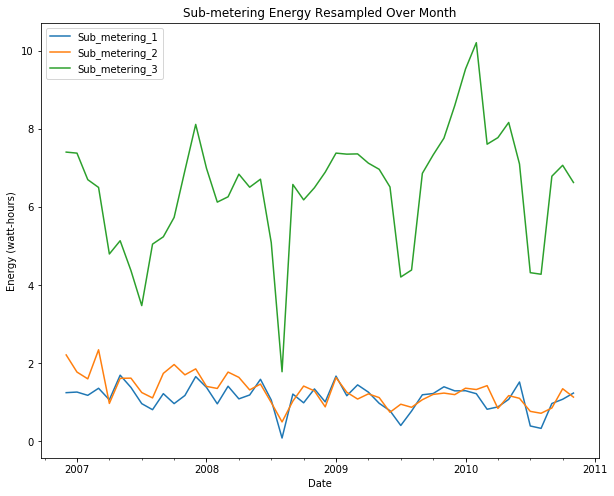

In [38]:
# Here, I resampled over the month
plt.figure(figsize=(10,8))
plt.tight_layout()
df.Sub_metering_1.resample('M').mean().plot()
df.Sub_metering_2.resample('M').mean().plot()
df.Sub_metering_3.resample('M').mean().plot()
plt.title('Sub-metering Energy Resampled Over Month')
plt.xlabel("Date")
plt.ylabel("Energy (watt-hours)")
plt.legend()
plt.show()

**Interpretation**
Because the data is quite noisy (the measurements are recorded by the minute), we first aggregate the variables by month, take the mean of that variable and plot these along with the data (month). This will give us a higher level look of how these variables change throughout the year (good for seasonal inspection). 

There appears to be a solid correlation between sub_metering_1 and sub_metering_2, however the correlation appears to be relatively weak with respect to sub_metering_3. In constructing a predictive model, we need to account for this correlation when selecting features. It also appears that the 3 distinct energy lows occurred simultaneously, and because these values appear to be significantly lower than the averages, this might indicate nobody was home during this time (vacation/vacant).

It is also quite clear that the majority of energy usage was due to heating/cooling, so this information could be useful to the tenants of this household to look at other sources for their heating and cooling needs (eg. wood stove/fans/gas).  

In [124]:
sub1 = df.Sub_metering_1.resample('M').mean().to_frame()
sub1["MA_7"] = sub1.Sub_metering_1.rolling(7, center=True).mean()
sub1["MA_7_std"] = sub1.Sub_metering_1.rolling(7, center=True).std()
sub2 = df.Sub_metering_2.resample('M').mean().to_frame()
sub2["MA_7"] = sub2.Sub_metering_2.rolling(7, center=True).mean()
sub2["MA_7_std"] = sub2.Sub_metering_2.rolling(7, center=True).std()
sub3 = df.Sub_metering_3.resample('M').mean().to_frame()
# nice to see a plot of the above, with it's rolling average and std
sub3["MA_7"] = sub3.Sub_metering_3.rolling(7, center=True).mean()
sub3["MA_7_std"] = sub3.Sub_metering_3.rolling(7, center=True).std()

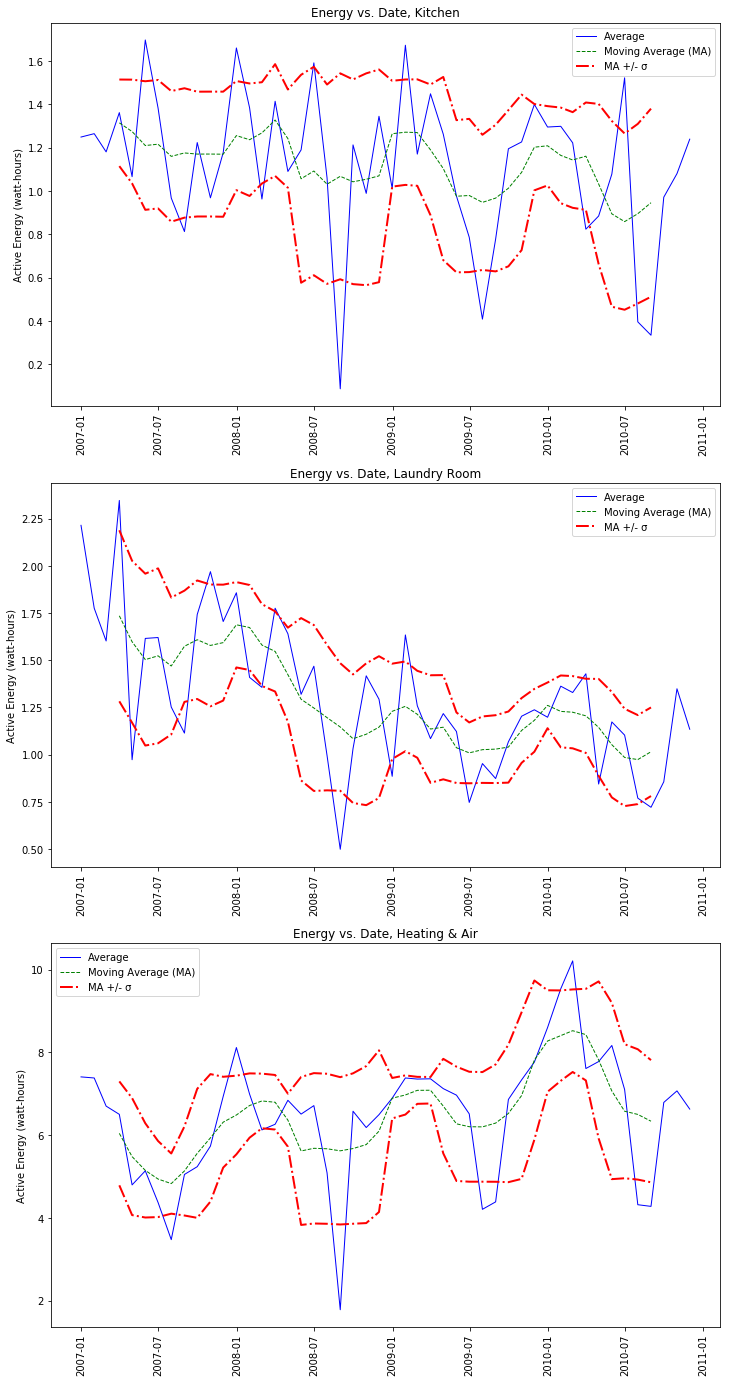

In [125]:
plt.figure(figsize=(12,24))
plt.grid(True)
plt.subplot(3,1,1)
plt.plot(sub1.Sub_metering_1, linewidth=1, color="blue", label = "Average")
plt.plot(sub1.MA_7, linestyle="dashed", color="green", linewidth=1, label="Moving Average (MA)")
plt.plot(sub1.MA_7 + sub1.MA_7_std, color="red", linestyle="-.", linewidth=2, label='MA +/- σ')
plt.plot(sub1.MA_7 - sub1.MA_7_std, color="red", linestyle="-.", linewidth=2)
plt.legend()
plt.xticks(rotation="vertical")
plt.title("Energy vs. Date, Kitchen")
plt.ylabel("Active Energy (watt-hours)")

plt.subplot(3,1,2)
plt.plot(sub2.Sub_metering_2, linewidth=1, color="blue", label = "Average")
plt.plot(sub2.MA_7, linestyle="dashed", color="green", linewidth=1, label="Moving Average (MA)")
plt.plot(sub2.MA_7 + sub2.MA_7_std, color="red", linestyle="-.", linewidth=2, label='MA +/- σ')
plt.plot(sub2.MA_7 - sub2.MA_7_std, color="red", linestyle="-.", linewidth=2)
plt.legend()
plt.xticks(rotation="vertical")
plt.title("Energy vs. Date, Laundry Room")
plt.ylabel("Active Energy (watt-hours)")

plt.subplot(3,1,3)
plt.plot(sub3.Sub_metering_3, linewidth=1, color="blue", label = "Average")
plt.plot(sub3.MA_7, linestyle="dashed", color="green", linewidth=1, label="Moving Average (MA)")
plt.plot(sub3.MA_7 + sub3.MA_7_std, color="red", linestyle="-.", linewidth=2, label='MA +/- σ')
plt.plot(sub3.MA_7 - sub3.MA_7_std, color="red", linestyle="-.", linewidth=2)
plt.legend()
plt.xticks(rotation="vertical")
plt.title("Energy vs. Date, Heating & Air")
plt.ylabel("Active Energy (watt-hours)")


plt.show()

**Interpretation**

Above we calculated the 7-day moving average (mean) and it's corresponding standard deviation for each sub-metering, and then plotted the observed monthly average (in blue), as well as the 7-day moving average (in green), and then plotted the interval we expect the average to fall within (the MA +/- the standard deviation). As we can see, this MA is a fairly good estimate of the observed average. Essentially what it means when the observed average (blue) falls below the MA (green) is that less energy was consumed than in the previous 7 day window, and vice versa when this line is above the MA. We can calculate this ratio: 

In [189]:
df_sub = df.Sub_metering_1.resample('D').mean().to_frame()
df_sub["Sub_metering_2"] = df.Sub_metering_2.resample('D').mean()
df_sub["Sub_metering_3"] = df.Sub_metering_3.resample('D').mean()
print("Correlation matrix: Averaged by Day")
print(df_sub.corr())
df_sub = df.Sub_metering_1.resample('W').mean().to_frame()
df_sub["Sub_metering_2"] = df.Sub_metering_2.resample('W').mean()
df_sub["Sub_metering_3"] = df.Sub_metering_3.resample('W').mean()
print("Correlation matrix: Averaged by Week")
print(df_sub.corr())
df_sub = df.Sub_metering_1.resample('M').mean().to_frame()
df_sub["Sub_metering_2"] = df.Sub_metering_2.resample('M').mean()
df_sub["Sub_metering_3"] = df.Sub_metering_3.resample('M').mean()
print("Correlation matrix: Averaged by Month")
print(df_sub.corr())

Correlation matrix: Averaged by Day
                Sub_metering_1  Sub_metering_2  Sub_metering_3
Sub_metering_1        1.000000        0.249159        0.301549
Sub_metering_2        0.249159        1.000000        0.196551
Sub_metering_3        0.301549        0.196551        1.000000
Correlation matrix: Averaged by Week
                Sub_metering_1  Sub_metering_2  Sub_metering_3
Sub_metering_1        1.000000        0.433571        0.536465
Sub_metering_2        0.433571        1.000000        0.322528
Sub_metering_3        0.536465        0.322528        1.000000
Correlation matrix: Averaged by Month
                Sub_metering_1  Sub_metering_2  Sub_metering_3
Sub_metering_1        1.000000        0.597398        0.563245
Sub_metering_2        0.597398        1.000000        0.294731
Sub_metering_3        0.563245        0.294731        1.000000


**Interpretation**

So the correlation between the different sub-metering are not as correlated as we expected from simply looking at the plots, however the correlation increases when averaging based on the day to averaging on the week and then the month. This is important when it comes to selecting features to use in a predictive model: collinearity among shared features leads to poor performance in such models. 

In [136]:
print(sum(sub1.Sub_metering_1 > (sub1.MA_7 + sub1.MA_7_std))/len(sub1.Sub_metering_1))
print(sum(sub2.Sub_metering_2 > (sub2.MA_7 + sub2.MA_7_std))/len(sub2.Sub_metering_2))
print(sum(sub3.Sub_metering_3 > (sub3.MA_7 + sub3.MA_7_std))/len(sub3.Sub_metering_3))

0.10416666666666667
0.10416666666666667
0.0625


So for both kitchen and laundry equipment, we saw the exact same percentage (10.4%) of total months where the amount of energy consumed was greater than the expected (based on a 7-day moving average). Heating & air energy consumed by month was less variable, as we saw only around 6% of months above the MA + one standard deviation.

In [138]:
print(sum(sub1.Sub_metering_1 < (sub1.MA_7 - sub1.MA_7_std))/len(sub1.Sub_metering_1))
print(sum(sub2.Sub_metering_2 < (sub2.MA_7 - sub2.MA_7_std))/len(sub2.Sub_metering_2))
print(sum(sub3.Sub_metering_3 < (sub3.MA_7 - sub3.MA_7_std))/len(sub3.Sub_metering_3))

0.16666666666666666
0.1875
0.14583333333333334


On the other end of the spectrum, we observed 16.7% of all months consumed less energy in the kitchen thank the MA minus one standard deviation, 18.75% of all months used less energy in the laundry room and 14.5% consumed less energy when it came to heating and cooling equipment. 

In [145]:
mask1 = (sub1.Sub_metering_1 <= (sub1.MA_7 + sub1.MA_7_std)) & (sub1.Sub_metering_1 >= (sub1.MA_7 - sub1.MA_7_std))
print(sum(mask1)/len(sub1.Sub_metering_1))
mask2 = (sub2.Sub_metering_2 <= (sub2.MA_7 + sub2.MA_7_std)) & (sub2.Sub_metering_2 >= (sub2.MA_7 - sub2.MA_7_std))
print(sum(mask2)/len(sub2.Sub_metering_2))
mask3 = (sub3.Sub_metering_3 <= (sub3.MA_7 + sub3.MA_7_std)) & (sub3.Sub_metering_3 >= (sub3.MA_7 - sub3.MA_7_std))
print(sum(mask3)/len(sub3.Sub_metering_3))

0.6041666666666666
0.5833333333333334
0.6666666666666666


Another way of putting this is that about 60% of all monthly energy consumption due to kitchen equipment fell within the range of the 7-day MA +/- one standard deviation, about 58% of all laundry equipment and around 67% of all heating & cooling related energy fell within this range. These statistics can provide insight to the energy company, that based on historical energy data future energy consumption can be predicted. 

If our data followed a normal distribution, we would expect to see 68% of all data fall within this range.

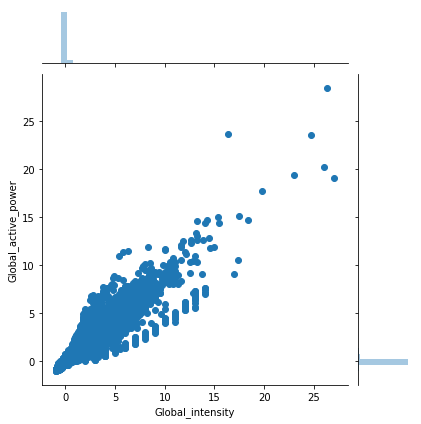

In [170]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  
plt.show()

However a strong correlation does appear to exist between Global_active_power and Global_intensity. This information can be useful in feature selection, as we might be able to group the 2 features into 1.

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


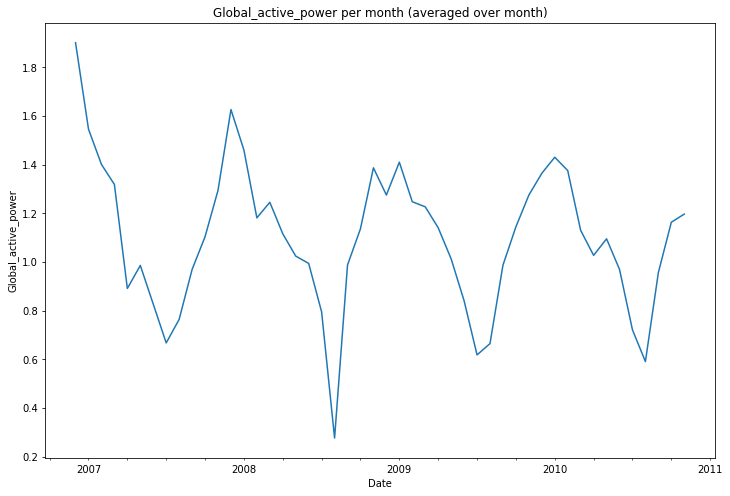

In [156]:
plt.figure(figsize=(12,8))
df['Global_active_power'].resample('M').mean().plot(kind='line')
#df.Global_intensity.resample('M').mean().plot(kind='line')
#plt.xticks(rotation=60)
plt.xlabel("Date")
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.tick_params(bottom="off")
plt.show()

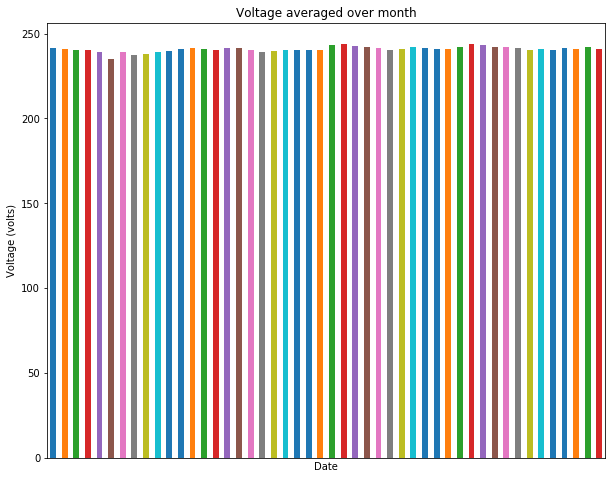

In [164]:
plt.figure(figsize=(10,8))
df.Voltage.resample('M').mean().plot(kind='bar')
plt.xticks([],[])
plt.xlabel("Date")
plt.ylabel("Voltage (volts)")
plt.title("Voltage averaged over month")
plt.show()

The above plot shows us that the voltage stayed constant over time, confirming our hypothesis stated above (in regarding the voltage).

In [30]:
hourly = df.groupby(df.index.hour).mean()
weekday = df.groupby(df.index.weekday).mean()
weekly = df.groupby(df.index.weekofyear).mean()
quarterly = df.groupby(df.index.quarter).mean()

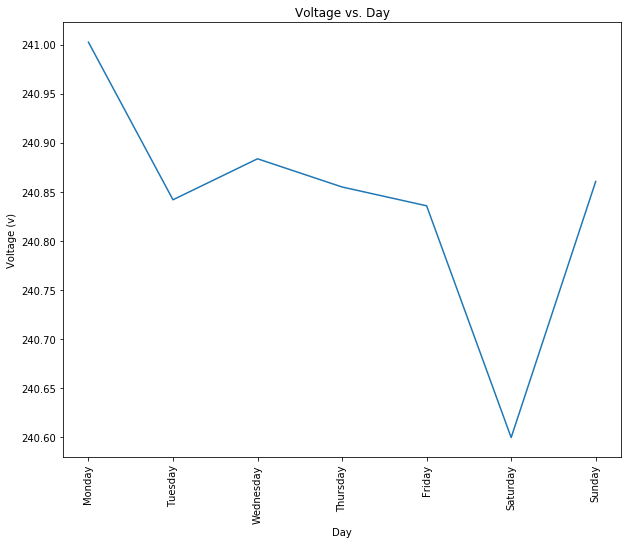

In [31]:
plt.figure(figsize=(10,8))
weekday.Voltage.plot()
plt.title("Voltage vs. Day")
plt.xlabel("Day")
plt.ylabel("Voltage (v)")
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
locs = [0,1,2,3,4,5,6]
plt.xticks(locs, days, rotation = "vertical")
plt.show()

**Interpretation:** 

While the plot above suggests that the voltage stays constant throughout one day, here we see that if we average the voltage over common days of the week there does appear to be a slight difference between weekdays and weekends.

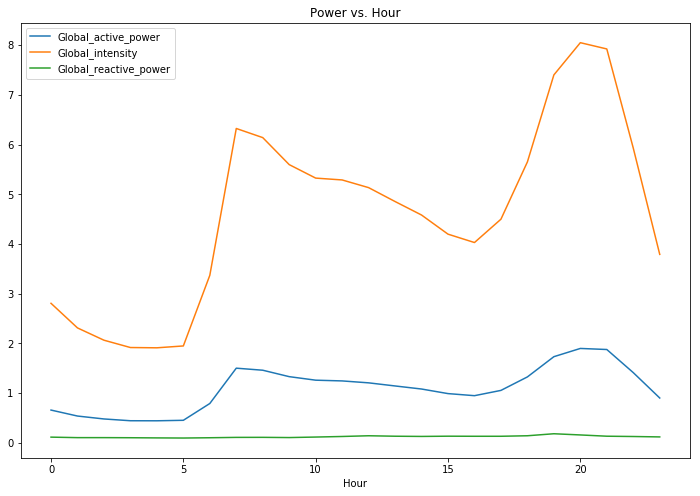

In [220]:
plt.figure(figsize=(12,8))
hourly.Global_active_power.plot()
hourly.Global_intensity.plot()
hourly.Global_reactive_power.plot()
plt.title("Power vs. Hour")
plt.xlabel("Hour")
plt.legend()
plt.show()

In [221]:
hourly.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.686576,-0.870645,0.999890,0.872612,0.602143,0.743240
Global_reactive_power,0.686576,1.000000,-0.571336,0.694837,0.790925,0.787976,0.272566
Voltage,-0.870645,-0.571336,1.000000,-0.873410,-0.693984,-0.540476,-0.779607
Global_intensity,0.999890,0.694837,-0.873410,1.000000,0.873903,0.606605,0.738912
Sub_metering_1,0.872612,0.790925,-0.693984,0.873903,1.000000,0.716464,0.526100
Sub_metering_2,0.602143,0.787976,-0.540476,0.606605,0.716464,1.000000,0.487876
Sub_metering_3,0.743240,0.272566,-0.779607,0.738912,0.526100,0.487876,1.000000


**Interpretation:** 

Since global_active_power represents the aggregation of the various sub-metering's, we expect to see significant correlation; this could be an issue when attempting to predict total power usage. One possible solution would be to see if these variables can be clustered.

global_active_power and global_intensity are highly correlated, we see an increase in both starting around 5 AM and do not see these values begin to decrease until around 9 PM. Global_reactive_power remains constant among the duration of a day.

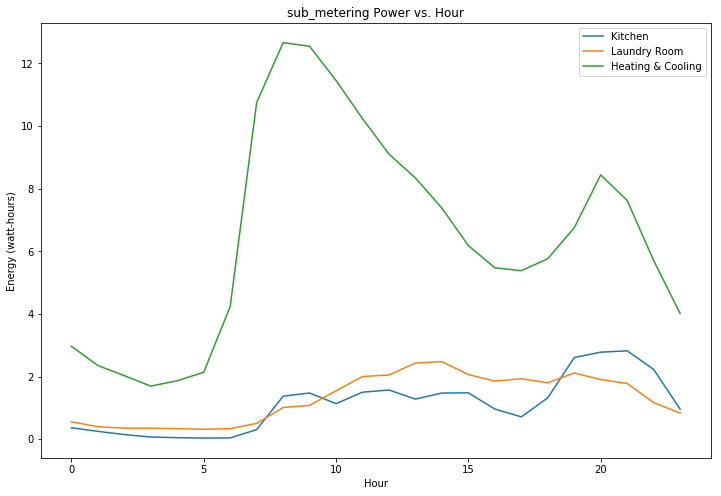

In [226]:
plt.figure(figsize=(12,8))
hourly.Sub_metering_1.plot(label = "Kitchen")
hourly.Sub_metering_2.plot(label = "Laundry Room")
hourly.Sub_metering_3.plot(label = "Heating & Cooling")
plt.title("sub_metering Power vs. Hour")
plt.xlabel("Hour")
plt.ylabel("Energy (watt-hours)")
plt.legend()
plt.show()

**Interpretation:** 

Little energy is consumed at night (midnight to around 5-6 AM), but the fact that heating & cooling power increases drastically after around 5 AM suggests that either someone is home during the day, or this household might be wasting power costs during the day.

This information can be utilized by the power utility in an effort to re-route power during different times of the day to areas of high power consumption (residential/industrial). 

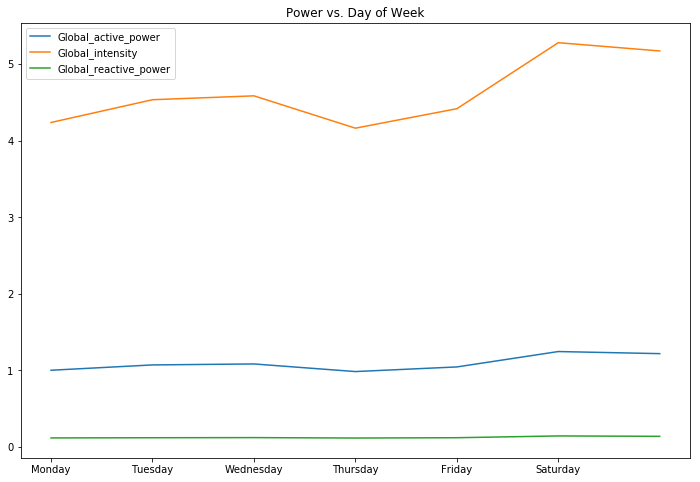

In [35]:
plt.figure(figsize=(12,8))
weekday.Global_active_power.plot()
weekday.Global_intensity.plot()
weekday.Global_reactive_power.plot()
plt.title("Power vs. Day of Week")
plt.xlabel("")
plt.xticks(range(0,6), days)
plt.legend()
plt.show()

**Interpretation:** 

As stated above, global_reactive_power remains constant throughout the week, and while we observed a high correlation among global_active_power and global_intensity when averaged on an hourly basis, this correlation appears to be quite minimal when averaging over the day of the week. (This was also validated above numerically). The main takeaway (for both the utility company and the consumer) is that power consumption appears to be higher during the weekends than during the week. We can test this hypothesis with a simple T-Test: 

In [36]:
print("Weekday average: {}".format(weekday.iloc[0:5,1].mean()))
print("Weekend average: {}".format(weekday.iloc[5:7,1].mean()))

Weekday average: 0.11747873205773349
Weekend average: 0.13933427371121088


In [243]:
ttest_ind(weekday.iloc[0:5,1].to_frame(),weekday.iloc[5:7,1].to_frame(), equal_var=False)

Ttest_indResult(statistic=array([-7.97094786]), pvalue=array([0.04516843]))

**Takeaways:** A p-value of 0.0451 suggests that there is a statistical difference in the mean Global_active_power consumed between weekdays and weekends.

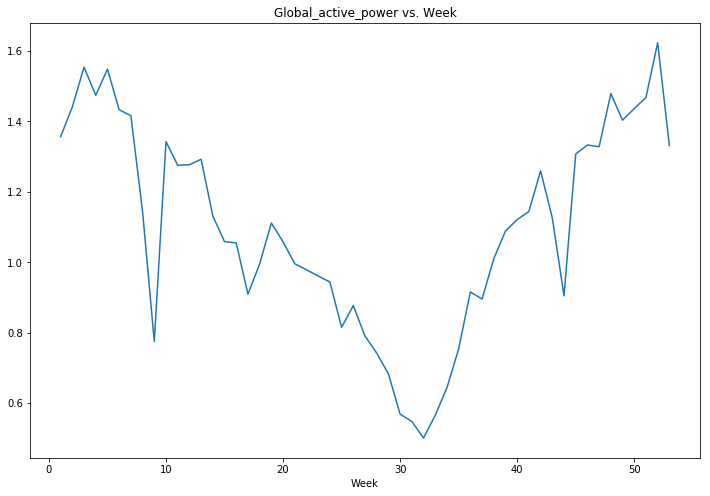

In [258]:
plt.figure(figsize=(12,8))
weekly.Global_active_power.plot()
plt.title("Global_active_power vs. Week")
plt.xlabel("Week")
plt.show()

**Interpretation:** 

It is interesting to note that if we aggregate the global_active_power variable over each week (1-52), we observe significant lows around week 32 (give or take 2 weeks, which equates to the end of July, beginning of August). This falls in the middle of Summer. Not surprisingly we see highs in the Winter (beginning/end of the year).

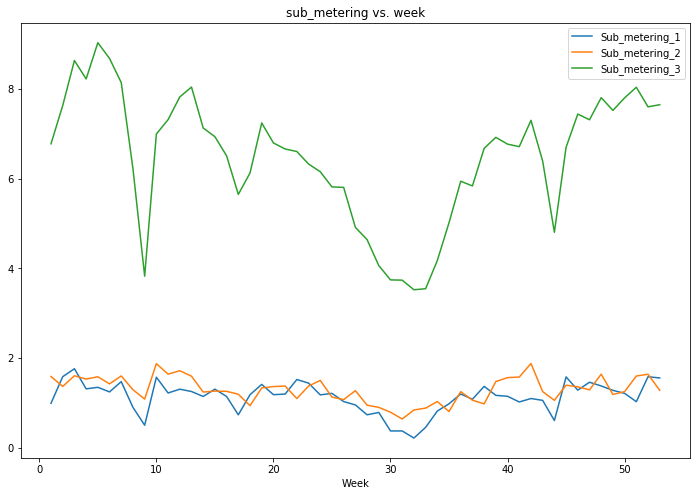

In [265]:
plt.figure(figsize=(12,8))
weekly.Sub_metering_1.plot()
weekly.Sub_metering_2.plot()
weekly.Sub_metering_3.plot()
plt.xlabel("Week")
plt.title("sub_metering vs. week")
plt.legend()
plt.show()

**Takeaways:** This plot exhibits trends common to that above (hourly), but once again we see that power usage is at an all time low during late-July, early-August. It would be interesting to see the temperatures around this time: does this household completely turn off their AC during the hottest (typically) part of the year? Are they on vacation? Was the house vacant?

In [45]:
july = df[(df.index.month==7) | (df.index.month==8)]
non_july = df[~(df.index.month==7) | (df.index.month==8)]

In [47]:
day = non_july.groupby(non_july.index.day).mean()
july_day = july.groupby(july.index.day).mean()

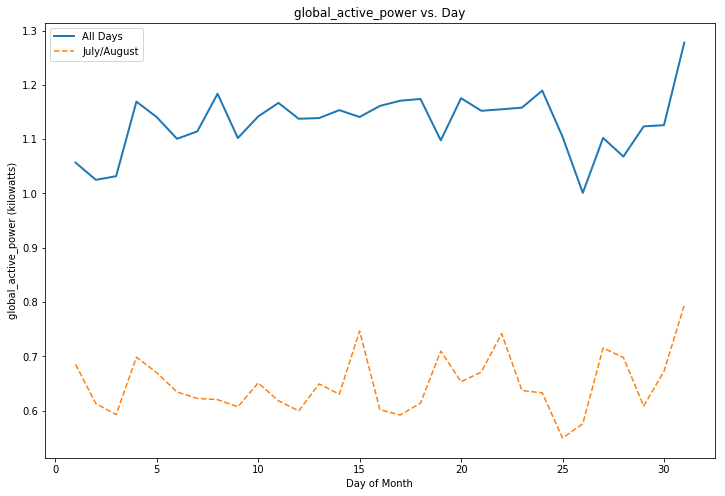

In [48]:
plt.figure(figsize=(12,8))
day.Global_active_power.plot(label="All Days", linewidth=2)
july_day.Global_active_power.plot(label="July/August", linestyle = "dashed")
plt.legend()
plt.title("global_active_power vs. Day")
plt.xlabel("Day of Month")
plt.ylabel("global_active_power (kilowatts)")
plt.show()

**Interpretation:** 

Above we plot the total power usage averaged over the day of the month, and we zoom into only July/August as an above plot showed us a minimum global_active_power occurred during the end of July, beginning of August. Note that the 2 plots appear to be offsets of each other, suggesting that this household had a baseline of power usage: 0.6485

In [40]:
july_day.Global_active_power.mean()

0.6485636281563404

In [49]:
day.Global_active_power.mean()

1.1304417966350742

In [50]:
1.1304417966350742 - 0.6485636281563404

0.48187816847873377

The gap (difference) of these 2 indicate that on average this house used an additional 0.48 kilowatts of power a day on days not in July or August. This information can be useful to the customer when it comes to budgeting. 